In [1]:
from pandas.errors import SettingWithCopyWarning

import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=DeprecationWarning)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

from keras.models import Sequential
from keras.layers import Dense

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import numpy as np

from keras import layers

import pandas as pd
import tensorflow as tf


data = pd.read_csv("datasets/wisco_2022.csv")

ModuleNotFoundError: No module named 'tensorflow'

In [183]:
from sklearn.utils import shuffle


dataframe = data[
    (data["Offpersonnelbasic"] != "Unknown") & (data["Offpersonnelbasic"] != "10 Men")
]

dataframe["Gainloss"] = dataframe["Gainloss"].replace(" ", np.nan, regex=True)

# created a new column that moved the yards gained or lost on a play down a row
dataframe["Yards on Previous Play"] = dataframe["Gainloss"].shift()
dataframe["previous_play"] = dataframe["Runpass"].shift()
dataframe["previous_playaction"] = dataframe["Playaction"].shift()

dataframe = dataframe[(dataframe["Runpass"] == "R") | (dataframe["Runpass"] == "P")]
# dataframe = dataframe[
#     (dataframe["previous_play"] == "R") | (dataframe["previous_play"] == "P")
# ]

if len(dataframe["Offpersonnelbasic"].unique()) > 10:
    personnel_packages = (
        dataframe.groupby(["Offpersonnelbasic"])["Offpersonnelbasic"]
        .agg(["count"])
        .reset_index()
    )
    dataframe = dataframe[
        ~dataframe["Offpersonnelbasic"].isin(
            personnel_packages[personnel_packages["count"] < 10]["Offpersonnelbasic"]
        )
    ]

dataframe = dataframe[dataframe["Down"] > 0]

subset = dataframe[
    [
        "Quarter",
        "Minutes Left",
        "Down",
        "Distance",
        "Fieldposition",
        "Offpersonnelbasic",
        "Runpass",
        "Yards on Previous Play",
        "Scoredifferential",
        "previous_play",
        "Hash",
        "previous_playaction",
    ]
]

cleaned_data = subset.dropna(
    subset=[
        "Quarter",
        "Minutes Left",
        "Down",
        "Distance",
        "Fieldposition",
        "Offpersonnelbasic",
        "Runpass",
        "Scoredifferential",
        "Yards on Previous Play",
        "previous_play",
        "Hash",
        "previous_playaction",
    ]
)


cleaned_data = cleaned_data.astype(
    {
        "Quarter": "float16",
        "Down": "float16",
        "Distance": "float16",
        "Fieldposition": "float16",
        "Scoredifferential": "float16",
        "Yards on Previous Play": "float16",
        "previous_play": "category",
        "Offpersonnelbasic": "category",
        "Runpass": "category",
        "Hash": "category",
        "previous_playaction": "category",
    }
)


cleaned_data_w_dummies = pd.get_dummies(
    cleaned_data,
    columns=["previous_play", "Offpersonnelbasic", "Hash", "previous_playaction"],
    dtype=np.float16,
)

cleaned_data_w_dummies = cleaned_data_w_dummies.drop_duplicates()

cleaned_data_w_dummies = shuffle(cleaned_data_w_dummies)


predictors = cleaned_data_w_dummies.columns.drop(["Runpass"])

# enc = OneHotEncoder()
# target = enc.fit_transform(cleaned_data_w_dummies[["Runpass"]])

scale = StandardScaler()
cleaned_data_w_dummies[predictors] = scale.fit_transform(
    cleaned_data_w_dummies[predictors]
)


x_train, x_test, y_train, y_test = train_test_split(
    cleaned_data_w_dummies[predictors],
    cleaned_data_w_dummies["Runpass"],
    test_size=0.3,
    random_state=0,
)


cleaned_data_w_dummies.head()

,Quarter,Minutes Left,Down,Distance,Fieldposition,Runpass,Yards on Previous Play,Scoredifferential,previous_play_P,previous_play_R,...,Offpersonnelbasic_20 (*),Offpersonnelbasic_21,Offpersonnelbasic_21 (*),Offpersonnelbasic_22,Offpersonnelbasic_22 (*),Hash_C,Hash_L,Hash_R,previous_playaction_0.0,previous_playaction_1.0
658,-1.329290,0.911236,0.234624,-1.044500,-0.971058,P,-0.095234,-0.299373,-0.709915,0.709915,...,-0.191215,2.135140,-0.271779,-0.223607,-0.147043,-0.473943,1.228352,-0.847456,0.282843,-0.282843
579,1.356128,0.807712,1.477914,-0.798045,0.636052,R,-0.460082,0.615547,-0.709915,0.709915,...,-0.191215,-0.468353,3.679465,-0.223607,-0.147043,-0.473943,1.228352,-0.847456,0.282843,-0.282843
549,-0.434151,-1.431549,-1.008665,0.434230,1.315984,P,1.272948,0.454091,1.408620,-1.408620,...,-0.191215,-0.468353,-0.271779,-0.223607,-0.147043,-0.473943,-0.814099,1.180002,0.282843,-0.282843
366,0.460989,0.641174,1.477914,-1.783865,-0.816528,R,-0.460082,1.207555,-0.709915,0.709915,...,-0.191215,2.135140,-0.271779,-0.223607,-0.147043,-0.473943,-0.814099,1.180002,0.282843,-0.282843
39,1.356128,1.192550,-1.008665,0.434230,0.914206,R,0.725675,1.369011,-0.709915,0.709915,...,-0.191215,-0.468353,-0.271779,-0.223607,-0.147043,-0.473943,-0.814099,1.180002,0.282843,-0.282843


In [184]:
from collections import Counter
from imblearn.over_sampling import RandomOverSampler

# there is a disperity between pass and run plays in the datasets.
# So, I oversampled the data so we can get an even amount of run and pass plays

ros = RandomOverSampler(random_state=42)
x_resampled, y_resampled = ros.fit_resample(x_train, y_train)

print("Playcall distribution after oversampling:", Counter(y_resampled))

enc = OneHotEncoder()
y_resampled = enc.fit_transform(y_resampled.to_numpy().reshape(-1, 1)).toarray()

y_test = enc.fit_transform(y_test.to_numpy().reshape(-1, 1)).toarray()

Playcall distribution after oversampling: Counter({'P': 214, 'R': 214})


In [185]:
from keras import regularizers
from keras.optimizers import Adam, SGD


epochs = 60
learning_rate = 0.01
decay_rate = learning_rate / epochs
momentum = 0.8

sgd = SGD(
    learning_rate=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False
)

n_features = cleaned_data_w_dummies[predictors].shape[1]

# kernel_regularizer=regularizers.l2(0.01),

model = Sequential(name="down-breaks1")


model.add(
    Dense(
        64,
        activation="relu",
        input_shape=(n_features,),
        kernel_regularizer=regularizers.l2(0.01),
        kernel_initializer="lecun_normal",
    )
)
model.add(layers.Dropout(0.3))
model.add(
    Dense(
        64,
        activation="relu",
        kernel_regularizer=regularizers.l2(0.01),
        kernel_initializer="lecun_normal",
    )
)
model.add(layers.Dropout(0.3))
model.add(
    Dense(
        64,
        activation="relu",
        kernel_regularizer=regularizers.l2(0.01),
        kernel_initializer="lecun_normal",
    )
)
model.add(layers.Dropout(0.3))
model.add(Dense(2, activation="softmax"))

model.compile(
    loss="binary_crossentropy", optimizer=Adam(learning_rate=0.0001), metrics="accuracy"
)
model.summary()

Model: "down-breaks1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1536      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 2)                

In [186]:
from keras.callbacks import EarlyStopping

np.random.seed(0)

tf.keras.backend.clear_session()

# monitor = EarlyStopping(monitor="val_loss", patience=5)

results = model.fit(
    x_resampled,
    y_resampled,
    epochs=200,
    batch_size=16,
    validation_data=(x_test, y_test),
    verbose=2,
)  # , callbacks=[monitor])

Epoch 1/200
27/27 - 0s - loss: 2.7509 - accuracy: 0.4930 - val_loss: 2.6745 - val_accuracy: 0.3977 - 367ms/epoch - 14ms/step
Epoch 2/200
27/27 - 0s - loss: 2.7083 - accuracy: 0.4790 - val_loss: 2.6304 - val_accuracy: 0.4327 - 24ms/epoch - 903us/step
Epoch 3/200
27/27 - 0s - loss: 2.6549 - accuracy: 0.4907 - val_loss: 2.5895 - val_accuracy: 0.4971 - 25ms/epoch - 908us/step
Epoch 4/200
27/27 - 0s - loss: 2.6183 - accuracy: 0.5257 - val_loss: 2.5520 - val_accuracy: 0.5497 - 24ms/epoch - 887us/step
Epoch 5/200
27/27 - 0s - loss: 2.5849 - accuracy: 0.5187 - val_loss: 2.5170 - val_accuracy: 0.6023 - 24ms/epoch - 885us/step
Epoch 6/200
27/27 - 0s - loss: 2.5446 - accuracy: 0.5257 - val_loss: 2.4861 - val_accuracy: 0.6199 - 25ms/epoch - 934us/step
Epoch 7/200
27/27 - 0s - loss: 2.5143 - accuracy: 0.5561 - val_loss: 2.4543 - val_accuracy: 0.6491 - 27ms/epoch - 985us/step
Epoch 8/200
27/27 - 0s - loss: 2.4764 - accuracy: 0.5794 - val_loss: 2.4249 - val_accuracy: 0.6901 - 24ms/epoch - 886us/step


<Axes: >

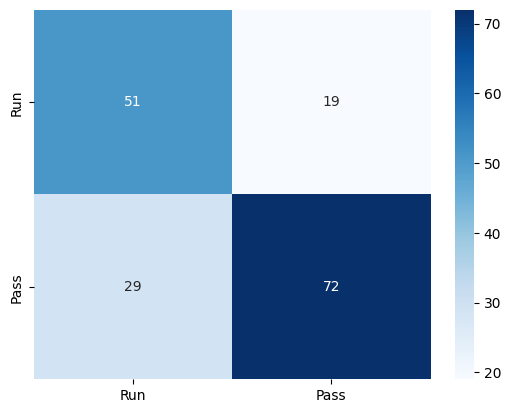

In [187]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

predictions = np.argmax(model.predict(x=x_test, batch_size=16, verbose=0), axis=-1)

y_labels = np.argmax(y_test, axis=-1)

cm = confusion_matrix(y_true=y_labels, y_pred=predictions)
sns.heatmap(
    cm,
    annot=True,
    cmap="Blues",
    xticklabels=["Run", "Pass"],
    yticklabels=["Run", "Pass"],
)

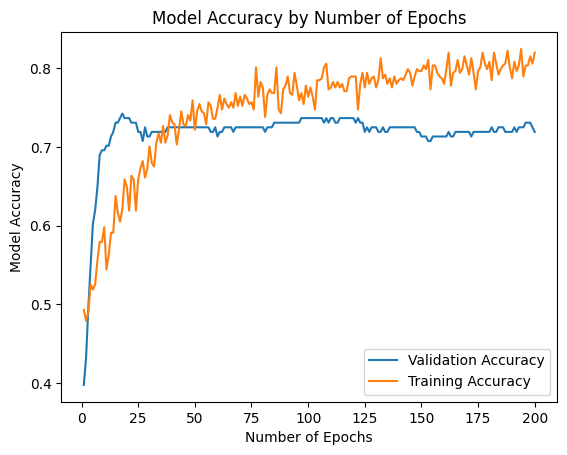

In [188]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(
    range(1, len(results.history["val_accuracy"]) + 1),
    results.history["val_accuracy"],
    label="Validation Accuracy",
)
plt.plot(
    range(1, len(results.history["accuracy"]) + 1),
    results.history["accuracy"],
    label="Training Accuracy",
)
plt.title("Model Accuracy by Number of Epochs")
plt.ylabel("Model Accuracy")
plt.xlabel("Number of Epochs")
plt.legend(loc="lower right")
plt.show()

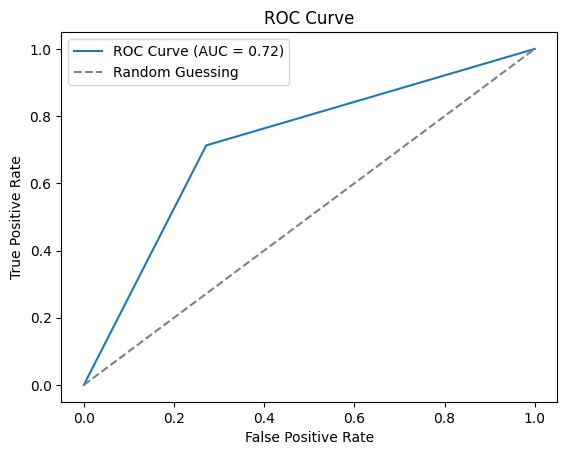

In [189]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

%matplotlib inline


auc = roc_auc_score(y_labels, predictions)
fpr, tpr, thresholds = roc_curve(y_labels, predictions)

plt.figure()
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

